# Przewidywanie cen domów v2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


#### 1. Załadownie danych

In [2]:
df = pd.read_csv('Dane/ames2000_NAfix.csv', delimiter=',', nrows=None)

#### 2. Analiza danych

In [3]:
nRow, nCol = df.shape
print(f'ilość wierszy {nRow} ilosc kolumn {nCol}')

ilość wierszy 2000 ilosc kolumn 80


In [4]:
df.head(5)

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,9,2006,New,Partial,342643


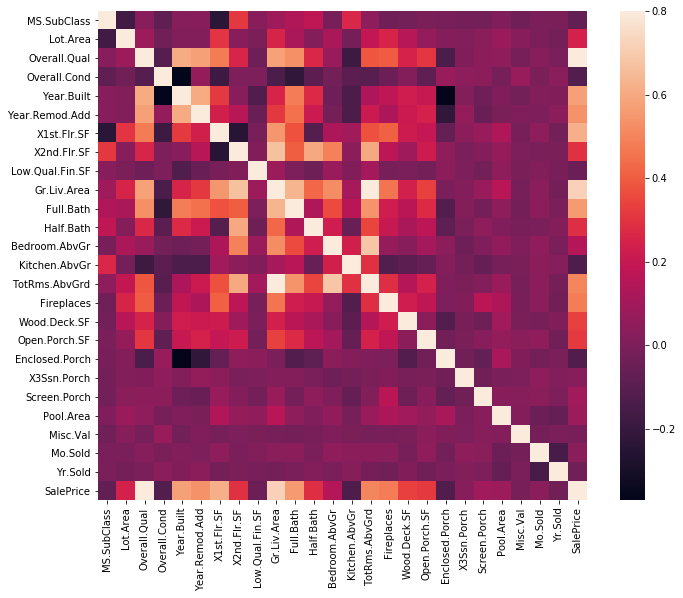

In [5]:
#macierz korealacji 
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

#### wyszukanie kolumn zaawierajacych puste wartosci

In [7]:
df.columns[df.isna().any()].tolist()

['Mas.Vnr.Type',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Garage.Finish',
 'Garage.Qual',
 'Garage.Cond']

#### uzupełnie pustych wartości

In [8]:
df['Mas.Vnr.Type'] = df['Mas.Vnr.Type'].fillna('None')
df['Bsmt.Qual'] = df['Bsmt.Qual'].fillna('None')
df['Bsmt.Cond'] = df['Bsmt.Cond'].fillna('None')
df['Bsmt.Exposure'] = df['Bsmt.Exposure'].fillna('None')
df['BsmtFin.Type.1'] = df['BsmtFin.Type.1'].fillna('None')
df['BsmtFin.Type.2'] = df['BsmtFin.Type.2'].fillna('None')
df['Garage.Finish'] = df['Garage.Finish'].fillna('None')
df['Garage.Qual'] = df['Garage.Qual'].fillna('None')
df['Garage.Cond'] = df['Garage.Cond'].fillna('None')

In [9]:
df.columns[df.isna().any()].tolist()

[]

#### patrzebujemy wartości numerycznych, przekształcamy kolumny z wartościami nie numerycznymi w zmienne dodatkowe, tylko zmienne kategoryczne

In [10]:
non_dummy_cols = df.select_dtypes(include=[np.number])

dummy_cols = list(set(df.columns) - set(non_dummy_cols))
data = pd.get_dummies(df, columns=dummy_cols)


In [11]:
data.columns[data.isna().any()].tolist()

[]

In [12]:
data.head(5)

,MS.SubClass,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,...,Sale.Type_ConLw,Sale.Type_New,Sale.Type_Oth,Sale.Type_VWD,Sale.Type_WD,Lot.Config_Corner,Lot.Config_CulDSac,Lot.Config_FR2,Lot.Config_FR3,Lot.Config_Inside
0,120,3901,6,5,2005,2006,1302,0,0,1302,...,0,1,0,0,0,0,0,0,0,1
1,20,8400,4,5,1970,1970,882,0,0,882,...,0,0,0,0,1,1,0,0,0,0
2,85,7200,5,8,1972,2003,768,0,0,768,...,0,0,0,0,1,0,0,0,0,1
3,90,7018,5,5,1979,1979,1535,0,0,1535,...,0,0,0,0,1,0,0,0,0,1
4,60,16259,9,5,2006,2006,1249,1347,0,2596,...,0,1,0,0,0,1,0,0,0,0


#### wyciągnięcie do y  wartość prognozowanej

In [13]:
y = data['SalePrice'].values
y

array([204000, 126000, 133900, ..., 233000, 134900, 180000])

#### reszta przypisana do X

In [14]:
X = data.drop('SalePrice', axis=1).values
X

array([[  120,  3901,     6, ...,     0,     0,     1],
       [   20,  8400,     4, ...,     0,     0,     0],
       [   85,  7200,     5, ...,     0,     0,     1],
       ...,
       [   60, 10142,     7, ...,     0,     0,     1],
       [   85,  7252,     5, ...,     0,     0,     0],
       [  160,  2998,     6, ...,     0,     0,     1]])

sprawdzam X

In [15]:
X.shape

(2000, 4254)

sprawdzam y

In [16]:
y.shape

(2000,)

In [17]:
y=y.reshape(-1,1)
y.shape

(2000, 1)

#### podział testu na zestwaw treningowy testowy, model będzie uczony na zestawie treningowym a zestaw testowy zostanie wykorzystany do jego oceny

In [18]:

X_train, X_test,y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=42)

### Wybór najlepszego modelu

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

Pipeline(memory=None,
     steps=[('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
R2 : 0.8217579115310835
MAE: 20643.889144259574
MSE: 1262184243.0487611
RMSE: 35527.23241470916


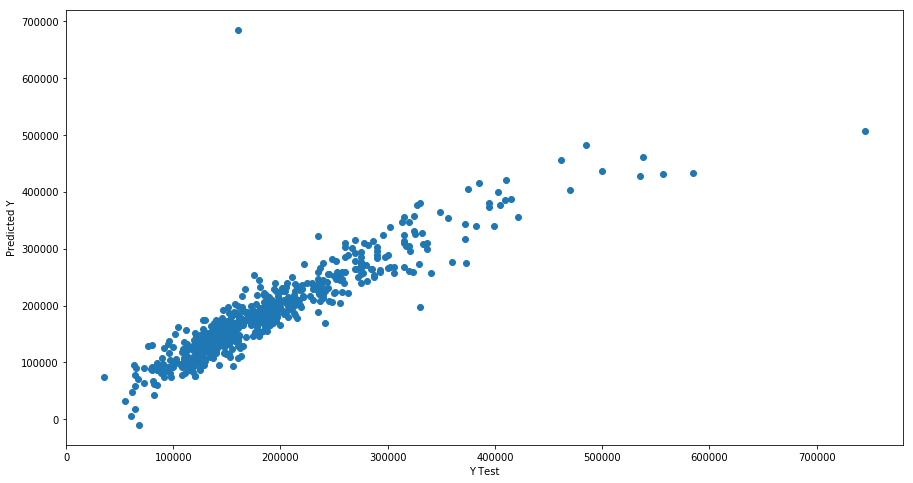

Pipeline(memory=None,
     steps=[('model', DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'))])
R2 : 0.7762168659710804
MAE: 23585.729381293593
MSE: 1584673676.445553
RMSE: 39807.95996337357


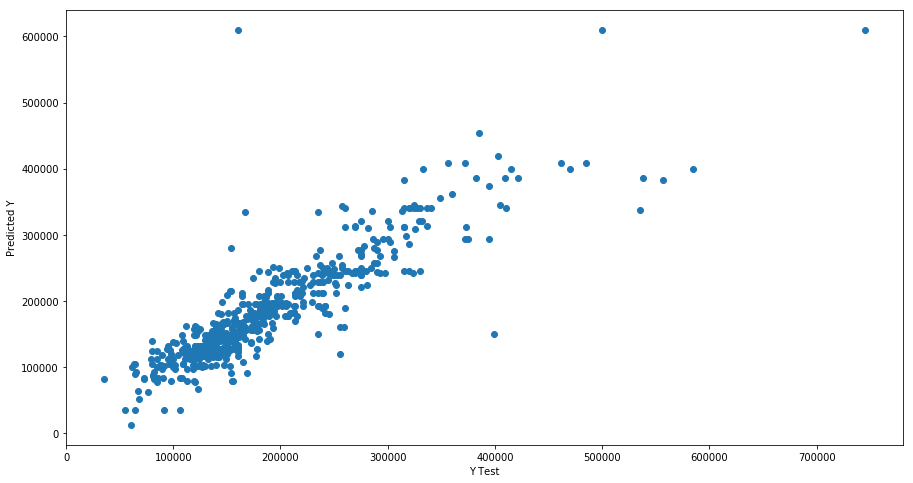

Pipeline(memory=None,
     steps=[('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
R2 : 0.8382357034623995
MAE: 18052.03355823614
MSE: 1145500189.8344152
RMSE: 33845.238805988876


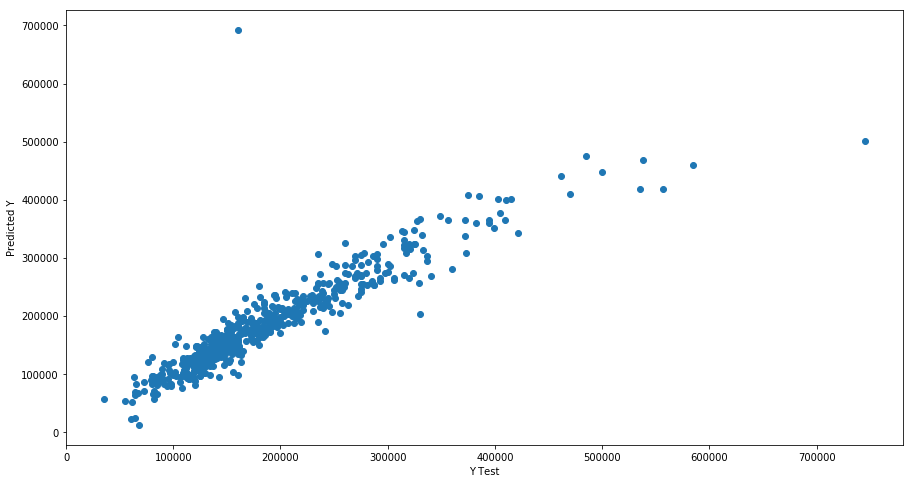

Pipeline(memory=None,
     steps=[('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
R2 : 0.8640768347891998
MAE: 17213.810483333335
MSE: 962511597.9512528
RMSE: 31024.371032323168


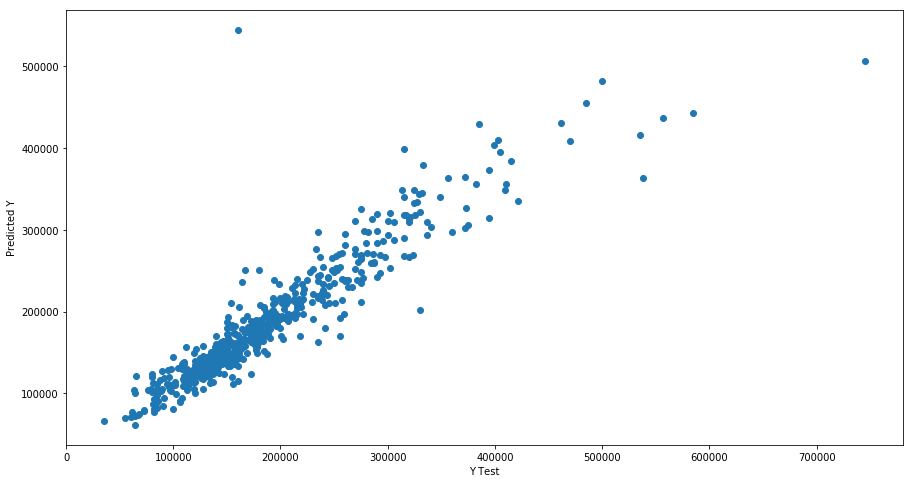

In [21]:
models = [[("model", linear_model.LinearRegression())] ,
         [ ("model", DecisionTreeRegressor())],
         [ ("model", linear_model.Ridge())],
         [ ("model", RandomForestRegressor())]]

param_grids = [{},
               {"model__max_depth": [None, 2, 10, 100], 
                "model__random_state": [42]} ,
               {"model__alpha":[0.2, 0.5, 0.7, 1.0]},
               {"model__n_estimators": [2, 5, 10, 100]}
              ]
best_models = []

list= []
i = 0
models_name = ['LinearRegression', 'DecisionTreeRegressor', 'Ridge', 'RandomForestRegressor']

for pipe, params in zip(models, param_grids):
    pipeline = Pipeline(pipe)
    gs = GridSearchCV(estimator=pipeline, param_grid=params, cv=10)
    gs.fit(X_train, y_train.ravel())
    best_models.append(gs.best_estimator_)   
    
for best_model in best_models:
    print(best_model)
    #dopasowanie do model
    r2 = best_model.score(X_test ,y_test)
    print("R2 :", r2)
    model_pred= best_model.predict(X_test)
    model_pred = model_pred.reshape(-1,1)
    #ceny mieszkan odchylają się o średni błąd bezwzgędny od wartośći rzeczywistej
    mae =  mean_absolute_error(y_test, model_pred)
    print('MAE:', mae)
    #błąd średniokwadratowy
    mse = mean_squared_error(y_test, model_pred)
    print('MSE:', mse)
    rmse = np.sqrt(mean_squared_error(y_test, model_pred))
    print('RMSE:', rmse)
    
    #wykres wartości przewidywanych od prawdziwych
    plt.figure(figsize=(15,8))
    plt.scatter(y_test, model_pred)
    plt.xlabel('Y Test')
    plt.ylabel('Predicted Y')
    plt.show()
    
    d = {'best models': models_name[i],
        'R2': r2, 
        'MAE': mae, 
        'MSE': mse,
        'RMSE' : rmse
    }
    list.append(d)
    i = i+1
    

### Podsumowanie

In [23]:
# zebranie wyników
df2 = pd.DataFrame(list)
df2

,MAE,MSE,R2,RMSE,best models
0,20643.889144,1.262184e+09,0.821758,35527.232415,LinearRegression
1,23585.729381,1.584674e+09,0.776217,39807.959963,DecisionTreeRegressor
2,18052.033558,1.145500e+09,0.838236,33845.238806,Ridge
3,17213.810483,9.625116e+08,0.864077,31024.371032,RandomForestRegressor


#### najlepsze wyniki uzyskał RandomForestRegressor